# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма.
    
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

--------------------------------------------
--------------------------------------------
--------------------------------------------

## Neural Style Transfer

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import time

In [3]:
dtype = torch.cuda.FloatTensor
imsize = 256

In [4]:
loader = transforms.Compose([
    transforms.Scale(imsize),
    transforms.ToTensor()])

C:\Users\fear_\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image

In [94]:
style_img = image_loader("manga.jpg").type(dtype)
style2_img = image_loader("zebra.jpg").type(dtype)
content_img = image_loader("cat.jpg").type(dtype)

In [95]:
assert style_img.size() == content_img.size()
assert style_img.size() == style2_img.size()

In [96]:
unloader = transforms.ToPILImage()
plt.ion()

In [97]:
def imshow(tensor, title = None):
    image = tensor.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [98]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph = True):
        self.loss.backward(retain_graph = True)
        return self.loss

In [99]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)

In [100]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph = True):
        self.loss.backward(retain_graph = True)
        return self.loss


In [101]:
cnn = models.vgg19(pretrained = True).features
cnn = cnn.cuda()

content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [102]:
def get_style_model_and_losses(cnn, style_img, style2_img, content_img,
                               style_weight = 700, content_weight = 1,
                               content_layers = content_layers_default,
                               style_layers = style_layers_default):
    cnn = copy.deepcopy(cnn)
    content_losses = []
    style_losses = []
    model = nn.Sequential()
    gram = GramMatrix()
    model = model.cuda()
    gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

                target_feature2 = model(style2_img).clone()
                target_feature_gram2 = gram(target_feature2)
                style_loss2 = StyleLoss(target_feature_gram2, style_weight)
                model.add_module("style_loss2_" + str(i), style_loss2)
                style_losses.append(style_loss2)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)

    return model, style_losses, content_losses

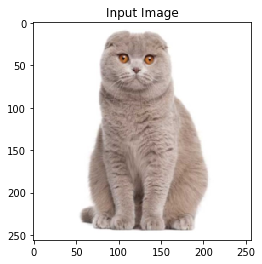

In [103]:
input_img = content_img.clone()

plt.figure()
imshow(input_img.data, title = 'Input Image')

In [104]:
def get_input_param_optimizer(input_img):
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [105]:
def run_style_transfer(cnn, content_img, style_img, style2_img, input_img, num_steps = 500, style_weight = 1000, content_weight = 1):

    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, style2_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_param.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_param)
            style_score = 0
            content_score = 0

            for cl in content_losses:
                content_score += cl.backward()
            for sl in style_losses:
                style_score += sl.backward()

            run[0] += 1
            if run[0] % 20 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data, content_score.data))
                print()

            if run[0] % 100 == 0:
                print("sleeping for some time")
                time.sleep(5)
                print("resuming...")

            return style_score + style_score

        optimizer.step(closure)

    input_param.data.clamp_(0, 1)

    return input_param.data

Building the style transfer model..
Optimizing..
run [20]:
Style Loss : 293.226440 Content Loss: 3.535247

run [40]:
Style Loss : 243.323990 Content Loss: 3.996630

run [60]:
Style Loss : 233.880554 Content Loss: 4.088018

run [80]:
Style Loss : 231.474350 Content Loss: 4.084349

run [100]:
Style Loss : 230.168610 Content Loss: 4.084375

sleeping for some time
resuming...
run [120]:
Style Loss : 229.579468 Content Loss: 4.059107

run [140]:
Style Loss : 229.268005 Content Loss: 4.017626

run [160]:
Style Loss : 229.077820 Content Loss: 3.981945

run [180]:
Style Loss : 228.980438 Content Loss: 3.927628

run [200]:
Style Loss : 228.895935 Content Loss: 3.896024

sleeping for some time
resuming...
run [220]:
Style Loss : 228.829117 Content Loss: 3.857327

run [240]:
Style Loss : 228.801514 Content Loss: 3.823102

run [260]:
Style Loss : 228.764038 Content Loss: 3.799298

run [280]:
Style Loss : 228.742310 Content Loss: 3.781930

run [300]:
Style Loss : 228.726028 Content Loss: 3.759691



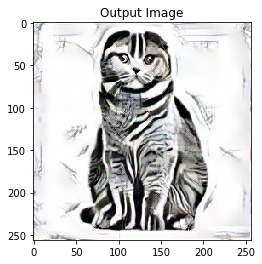

In [106]:
output = run_style_transfer(cnn, content_img, style_img, style2_img, input_img)

plt.figure()
imshow(output, title = 'Output Image')

plt.ioff()
plt.show()